In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers
!pip install pytorch_lightning
!pip install speechrecognition
!pip install pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 19.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
import random

from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy,auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from tensorflow.keras.models import load_model
import librosa
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import math

from pydub import AudioSegment

import cv2
import os
import speech_recognition as sr


## Text Model

In [ ]:
class classificationTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
# Load the BertModel object from the pickle file
with open("/content/drive/MyDrive/models/bert_model.pkl", "rb") as f:
    pmodel = pickle.load(f)

In [ ]:
def logits_to_probs(logits):
    # assuming `logits` is a 1D numpy array of unnormalized probabilities

    # apply the softmax function to the logits
    # print("Logits",logits)
    exp_logits = np.exp(logits)
    # print(exp_logits)
    probs = exp_logits / np.sum(exp_logits)
    # print("probs",probs)
    return probs

def predict(test_message):
  LABEL_COLUMNS = ['Cagtegory_agreeableness',
 'Cagtegory_conscientiousness',
 'Cagtegory_extraversion',
 'Cagtegory_neuroticism',
 'Cagtegory_openness']
  encoding = tokenizer.encode_plus(
  test_message,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
  )
  _, test_prediction = pmodel(encoding["input_ids"], encoding["attention_mask"])
  test_prediction = test_prediction.detach().numpy()
  # print("1",test_prediction)
  test_prediction = logits_to_probs(test_prediction)
  # print("2",test_prediction)
  dic={}
  k=0
  for label, prediction in zip(LABEL_COLUMNS, list(test_prediction[0])):
    dic[k] = prediction
    k+=1
  return dic

In [ ]:
test_message = "You are such a loser! You'll regret everything you've done to me!"
print(predict(test_message))

{0: 0.2232054, 1: 0.19815552, 2: 0.21611694, 3: 0.18823007, 4: 0.17429207}


## Audio Model

In [ ]:
with open("/content/drive/MyDrive/models/audio_model.pkl", "rb") as f:
  amodel = pickle.load(f)

In [ ]:
class find_ans :
  def __init__(self,model=amodel,output_path="."):
    self.model=model
    self.dic = {0: 'agreeableness',
                1: 'conscientiousness',
                2: 'extraversion',
                3: 'neuroticism',
                4: 'openness'}
    self.opath = output_path
  def audio_to_spec(self,aud) :
    signal, sr = librosa.load(aud, sr=22050)
    size = signal.shape[0]
    start = 0
    # print("Im at 1")
    end = start + math.floor(size/5)
    for i in range(5):
        part_of_signal = signal[start:end]
        mfcc = librosa.feature.mfcc(y=part_of_signal,
                    n_fft=2048,
                    hop_length=512,
                    n_mfcc=13)
        librosa.display.specshow(mfcc, sr=sr, hop_length=512)
        plt.savefig(f"{self.opath}/test_img_{i}.png")
        plt.axis('off')
        plt.clf()
        start = end
        end = start + math.floor(size/5)
  def predict(self,aud):
    self.audio_to_spec(aud)
    results = []
    for i in range(5):
      matrix = image.load_img(f"{self.opath}/test_img_{i}.png",target_size=(224,224))
      matrix = image.img_to_array(matrix)
      pred = self._predict(matrix)
      # print(i)
      results.append(pred)
      # from collections import Counter
      # return Counter(results).most_common()[0][0]
    averaged_probs = np.mean(results, axis=0)
    # print(averaged_probs)
    dfinal={}
    k=0
    for j in self.dic:
      dfinal[j]=averaged_probs[0][k]
      k+=1
    return dfinal
  def _predict(self,specgram):
    specgram = specgram/255.0
    specgram = specgram.reshape(1,specgram.shape[0],specgram.shape[1],specgram.shape[2])
    prediction = self.model.predict(specgram)
    return prediction
    # self.result.append(prediction)
    # print(prediction)
    # prediction = np.argmax(prediction)
    # return self.dic[prediction]

In [ ]:
obj = find_ans(amodel)

In [ ]:
# obj.predict("/content/drive/MyDrive/audio_train_test/test/extraversion/JIYZTruMpiI.003.wav")

## Image Model

In [ ]:
def image_predict(img_path,IMG_SIZE=200):
  testing = []

  for img in os.listdir(img_path):   #os.listdir(path)
    img_array = cv2.imread(os.path.join(img_path,img))
    # print(type(img_array))
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    testing.append(new_array)

  random.shuffle(testing)

  testing = np.array(testing).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

  testing = testing.astype('float32')
  testing /= 255
  with open("/content/drive/MyDrive/models/image_model.pkl", "rb") as f:
      imodel = pickle.load(f)
  # results=[]
  results=imodel.predict(testing)
  # print(results)
  averaged_probs = np.mean(results, axis=0)
  dic = {}
  k=0
  # print(averaged_probs)
  for j in averaged_probs:
    dic[k]=j
    k+=1
  return dic
# image_predict("/content/test_image")

## Main driver code with fusion

In [ ]:
import seaborn as sns

def plotproba(x, y,video_name):
    plt.figure(figsize=(8, 5))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=x, y=y, palette="rocket")

    # set the y-axis label and title
    ax.set_ylabel('Probability')
    ax.set_title(f'{video_name} Prediction')

    # set the y-axis limits to 0 and 1
    ax.set_ylim([0, 1])

    # rotate x-axis labels
    plt.xticks(rotation=90)

    # add value labels on bars
    for i, v in enumerate(y):
        ax.text(i, v+0.05, str(round(v,2)), ha='center', fontsize=10, fontweight='bold')

    # display the plot
    plt.show()


In [ ]:
labels = {0: 'agreeableness',
                1: 'conscientiousness',
                2: 'extraversion',
                3: 'neuroticism',
                4: 'openness'}

In [ ]:
def actual_plot(vname):
  df = pd.read_csv("/content/drive/MyDrive/Master_Text.csv")
  df.drop(["interview","Unnamed: 0"],axis=1,inplace=True)
  df = df.reindex(columns=['Video_Name','Text','agreeableness', 'conscientiousness','extraversion','neuroticism','openness'])
  actual=df.loc[df.Video_Name==vname,df.columns[2:7]].values[0]
  actual_probs = logits_to_probs(actual)
  plotproba(list(labels.values()),actual_probs,vname)


In [ ]:
def main(old_folder_path, IMG_SIZE=200):
  labels = {0: 'agreeableness',
                1: 'conscientiousness',
                2: 'extraversion',
                3: 'neuroticism',
                4: 'openness'}
  img_path= None
    # Loop through all files in the folder
  for filename in os.listdir(old_folder_path):
    # Check if the current file is a video file
    if not filename.lower().endswith((".mp4")):
        continue
    # Path to the current video file
    video_path = os.path.join(old_folder_path, filename)
    # Name of the current video file
    video_name = os.path.splitext(filename)[0]
    print("Video Name : ",video_name)
    # Path to the folder where the frames will be saved
    new_folder_path = os.path.join(old_folder_path, 'image')
    output_path = new_folder_path
    img_path=output_path
    # Create the output folder if it doesn't already exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Read the video file
    cap = cv2.VideoCapture(video_path)
    # Get the total number of frames in the video
    num_frames = 30 #int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Loop through each frame and save it as an image
    for i in range(num_frames):
        # Set the current frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        # Read the current frame
        ret, frame = cap.read()
        # Construct the output filename for the current frame
        output_filename = f"{video_name}_{i}.jpg"
        # Save the current frame as an image
        cv2.imwrite(os.path.join(output_path, output_filename), frame)
    # Release the video capture object
    cap.release()


    ##Audio splitting
    audio = AudioSegment.from_file(video_path, format="mp4")
    audio_folder_path = os.path.join(old_folder_path, 'audio')
    if not os.path.exists(audio_folder_path):
        os.makedirs(audio_folder_path)
    wav_file = f"{audio_folder_path}/{video_name}.wav"
    # # export the audio as WAV
    audio.export(wav_file, format="wav")


    #Text splitting
    text_folder = os.path.join(old_folder_path, 'text')
    if not os.path.exists(text_folder):
        os.makedirs(text_folder)

    r = sr.Recognizer()

    # loop through all audio files in the audio folder
    for audio_filename in os.listdir(audio_folder_path):
      if audio_filename.endswith(".wav"):
        # specify the path to the current audio file
        audio_path = os.path.join(audio_folder_path, audio_filename)

        # use the recognizer to open the audio file and recognize the speech
        with sr.AudioFile(audio_path) as source:
            audio_text = r.record(source)

        # use the recognizer to convert the speech to text
        text = r.recognize_google(audio_text)

        # create the path to the new text file and write the text to it
        text_filename = audio_filename[:-4] + ".txt"
        text_path = os.path.join(text_folder, text_filename)
        with open(text_path, "w") as text_file:
            text_file.write(text)

    #Prediction
    print("Image Prediction Started: ")
    image_preds = image_predict(img_path)
    print("Audio Prediction Started: ")
    spectro_folder = os.path.join(audio_folder_path, 'spectro')
    if not os.path.exists(spectro_folder):
      os.makedirs(spectro_folder)
    obj = find_ans(amodel,spectro_folder)
    audio_preds = obj.predict(wav_file)
    print("Text Prediction Started: ")
    f = open(f"{text_path}","r")
    ttext = f.readlines()[0]
    text_preds = predict(ttext)
    print("Text : ",ttext)
    # print(image_preds,audio_preds,text_preds)
    weighted_probs = 0.1 * np.array(list(audio_preds.values()))  + 0.45 * np.array(list(image_preds.values())) + 0.45 * np.array(list(text_preds.values()))
    print(weighted_probs)
    # shutil.rmtree(new_folder_path)
    # shutil.rmtree(audio_folder_path)
    # shutil.rmtree(text_folder)
    plotproba(list(labels.values()),weighted_probs,video_name)

Video Name :  in-HuMgiDCE.001
Image Prediction Started: 
1/1 [==============================] - 8s 8s/step
Audio Prediction Started: 
1/1 [==============================] - 0s 21ms/step
Text Prediction Started: 
Text :  I just really awkward because that's kind of what I'm finding myself being drawn to do more and stuff that's like more serious is stuff that I find myself really wanting to do but I feel
[0.10261404 0.10501582 0.19949079 0.49373007 0.09914928]


<Figure size 640x480 with 0 Axes>

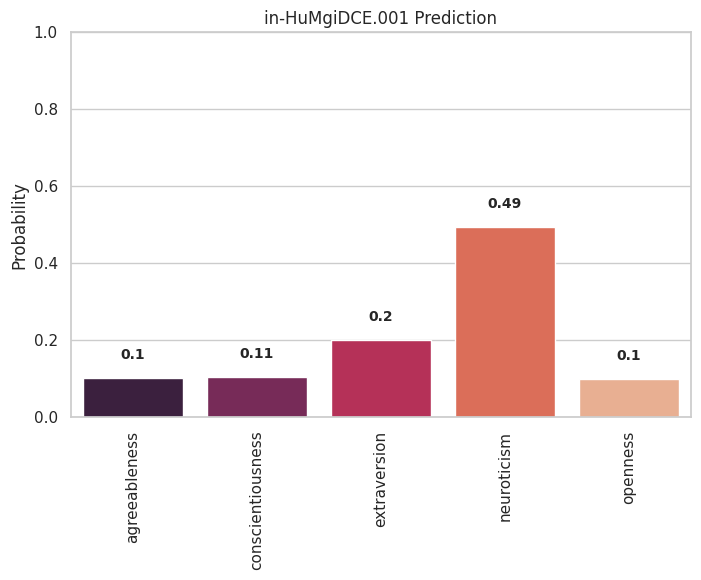

In [ ]:
main("/content/drive/MyDrive/nba_1")

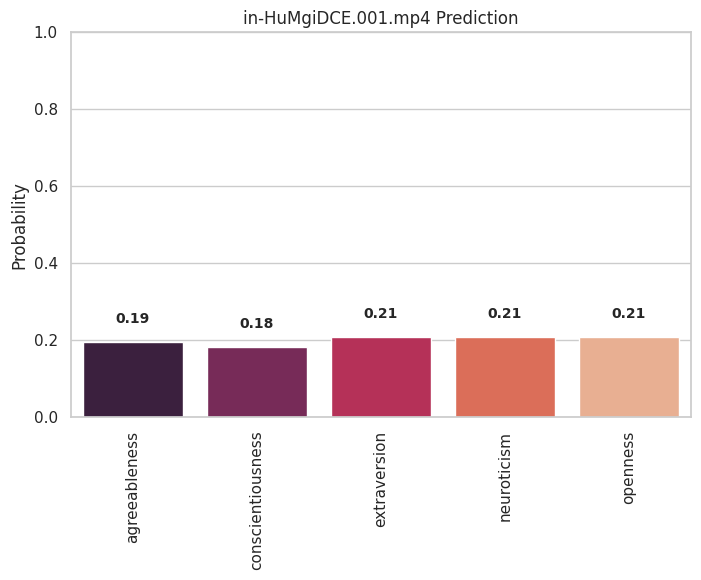

In [ ]:
actual_plot("in-HuMgiDCE.001.mp4")

Video Name :  B9NSU6gQdRw.005
Image Prediction Started: 
1/1 [==============================] - 0s 82ms/step
Audio Prediction Started: 
1/1 [==============================] - 0s 19ms/step
Text Prediction Started: 
Text :  360 view of the video as well so while I'm doing that Q&A I will be recording with the bubble Cam and I don't know I thought
[0.10478462 0.09050221 0.1987626  0.13142414 0.47452646]


<Figure size 640x480 with 0 Axes>

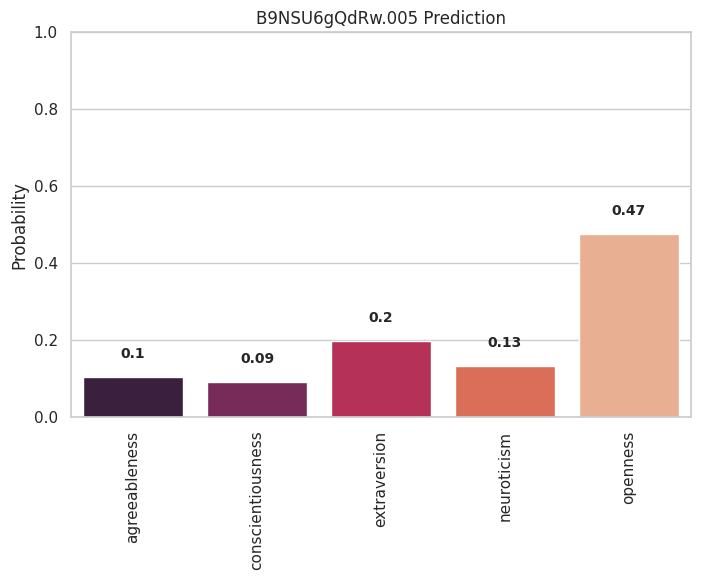

In [ ]:
main("/content/drive/MyDrive/nba_2")

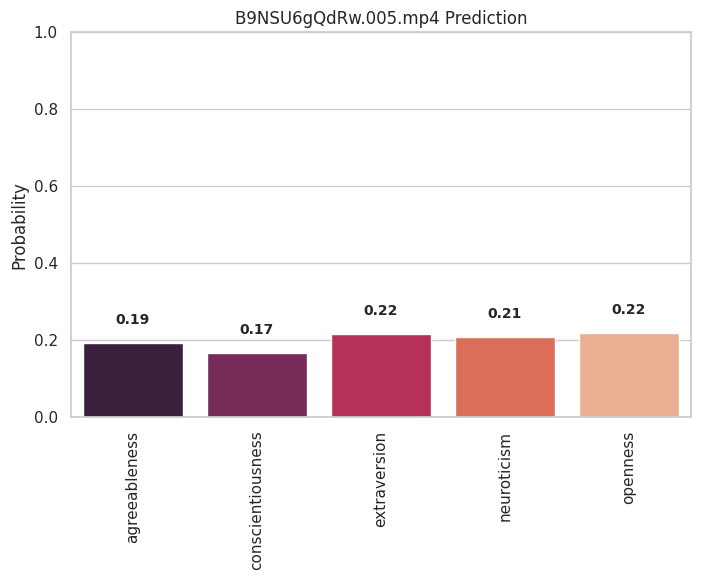

In [ ]:
actual_plot("B9NSU6gQdRw.005.mp4")

In [ ]:
main("/content/drive/MyDrive/nba_3")

Video Name :  geXpIfaFzF4.001


FileNotFoundError: ignored

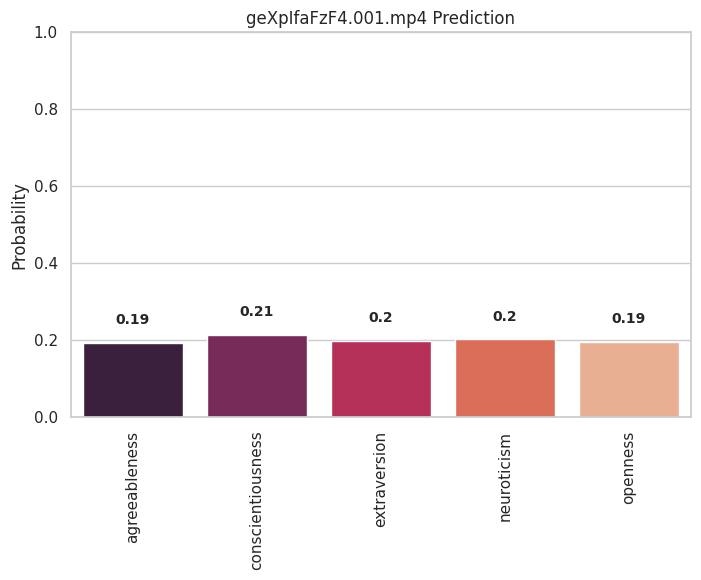

In [ ]:
actual_plot("geXpIfaFzF4.001.mp4")

Video Name :  A3StIKMjn4k.002
Image Prediction Started: 
1/1 [==============================] - 0s 145ms/step
Audio Prediction Started: 
1/1 [==============================] - 0s 31ms/step
Text Prediction Started: 
Text :  and then when I did see it I slammed on the brakes and of course I came off the motorcycle and I was very lucky that there were no cars or trucks behind me and I just kind of came off and then spun and got out of the way but obviously
[0.11604774 0.11451484 0.20518576 0.3821434  0.1821083 ]


<Figure size 640x480 with 0 Axes>

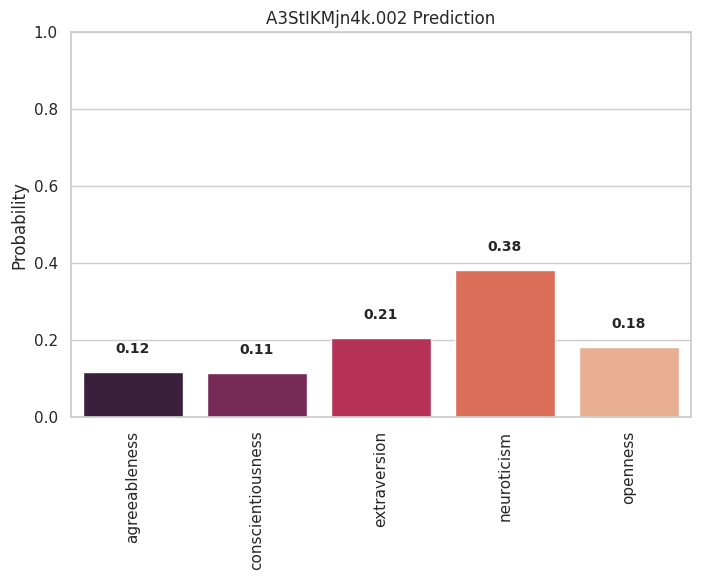

In [ ]:
main("/content/drive/MyDrive/test")

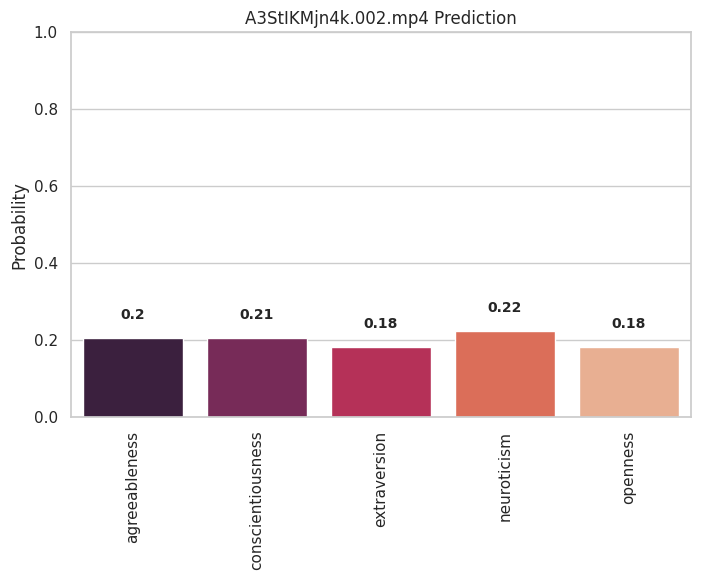

In [ ]:
actual_plot("A3StIKMjn4k.002.mp4")

Video Name :  _uNup91ZYw0.002
Image Prediction Started: 
1/1 [==============================] - 0s 80ms/step
Audio Prediction Started: 
1/1 [==============================] - 0s 29ms/step
Text Prediction Started: 
Text :  are the short answer is that I really wanted to write this book because I absolutely love writing popular histories I mean I love the Deep detailed history of course this is this is my thing but I love being able to share these stories in a way that makes it really accessible and exciting for people that wouldn't nessus
[0.10181533 0.35236466 0.20316312 0.1222159  0.22044098]


<Figure size 640x480 with 0 Axes>

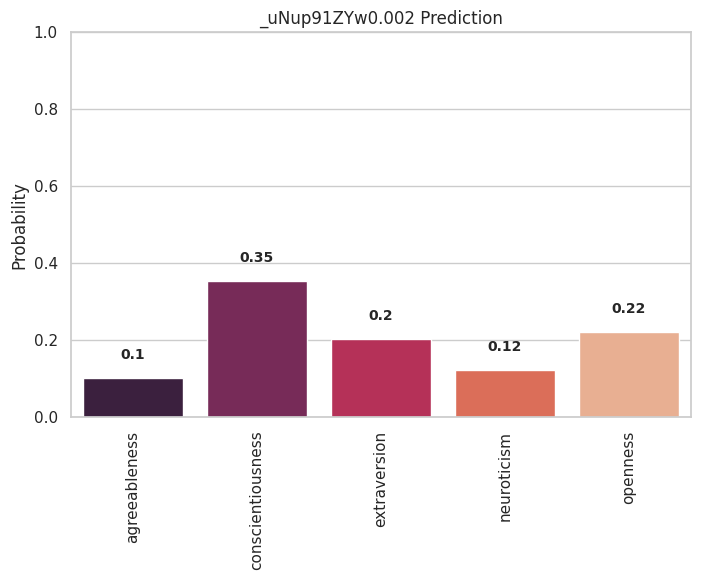

In [ ]:
main("/content/drive/MyDrive/test2/test2.2")

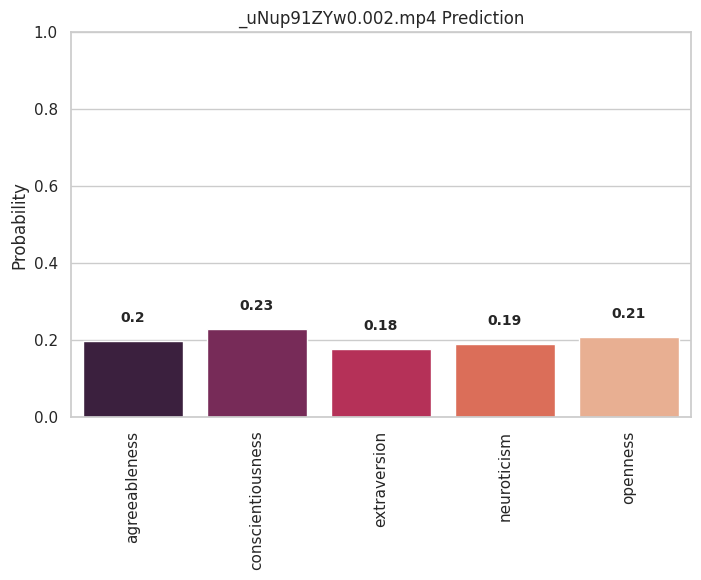

In [ ]:
actual_plot("_uNup91ZYw0.002.mp4")

In [ ]:
main("/content/drive/MyDrive/test2/test2.1")

Video Name :  BWAEpai6FK0.003


UnknownValueError: ignored

In [ ]:
actual_plot("BWAEpai6FK0.003.mp4")

Video Name :  VID-20230411-WA0032
Image Prediction Started: 
1/1 [==============================] - 7s 7s/step
Audio Prediction Started: 
1/1 [==============================] - 0s 37ms/step
Text Prediction Started: 
Text :  happy birthday and I believe I have a great day and last year a beautiful views with you are in my life and all the time that I think this is sweet heart with you and I will always be with you so so much
[0.12109947 0.22359745 0.29739782 0.19866282 0.15924242]


<Figure size 640x480 with 0 Axes>

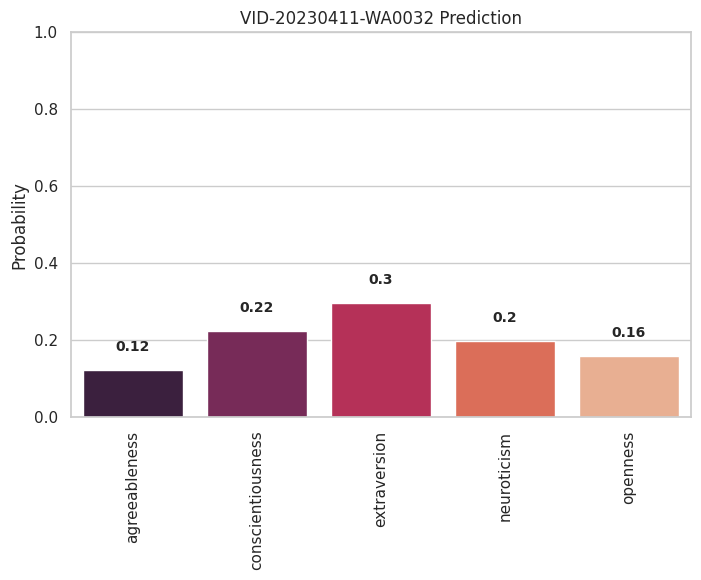

In [ ]:
main("/content/drive/MyDrive/prednya_test")

In [ ]:
main("/content/drive/MyDrive/pondi_test")

Video Name :  Pondy test


UnknownValueError: ignored

Video Name :  harsha test
Image Prediction Started: 
1/1 [==============================] - 0s 90ms/step
Audio Prediction Started: 
1/1 [==============================] - 0s 21ms/step
Text Prediction Started: 
Text :  so what kind of a person I am I am basically interesting person I usually mingle with people I like to know about others I am very friendly and listen to others opinions
[0.11021818 0.11525731 0.22075284 0.40873075 0.14504087]


<Figure size 640x480 with 0 Axes>

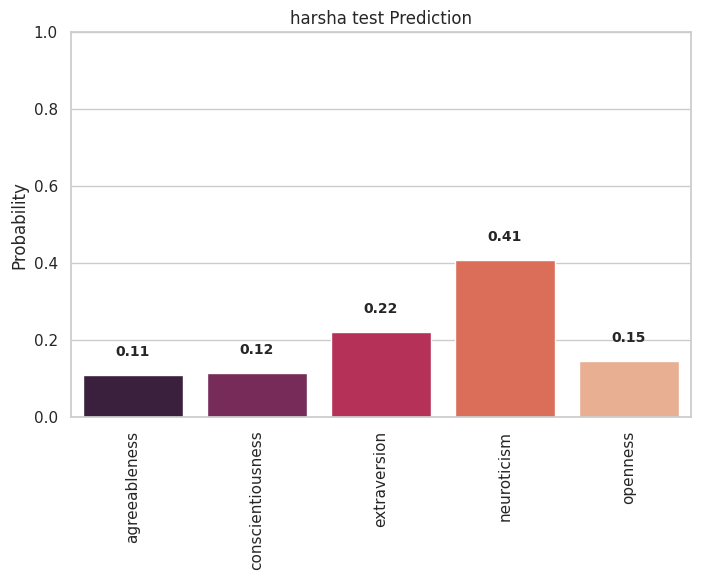

In [ ]:
main("/content/drive/MyDrive/harsha_test")

Video Name :  e8cc3233-cd17-4ffe-881c-10b43910a185
Image Prediction Started: 
1/1 [==============================] - 0s 93ms/step
Audio Prediction Started: 
1/1 [==============================] - 0s 20ms/step
Text Prediction Started: 
Text :  hi this is Sri Vignesh I'm going to talk about my experience at least in Bangalore it was pretty fruitful and I have worked in multiple projects which actually helped me get better at stuff that I was not sure that I will be doing better including business and management and a lot more stuff they have offered me a bit of an offer but I did not I don't know whether I will take it or not and it also helped me get better at my English because I had an opportunity to talk to a lot of people this video
[0.10480469 0.21322343 0.19558674 0.3894633  0.09692176]


<Figure size 640x480 with 0 Axes>

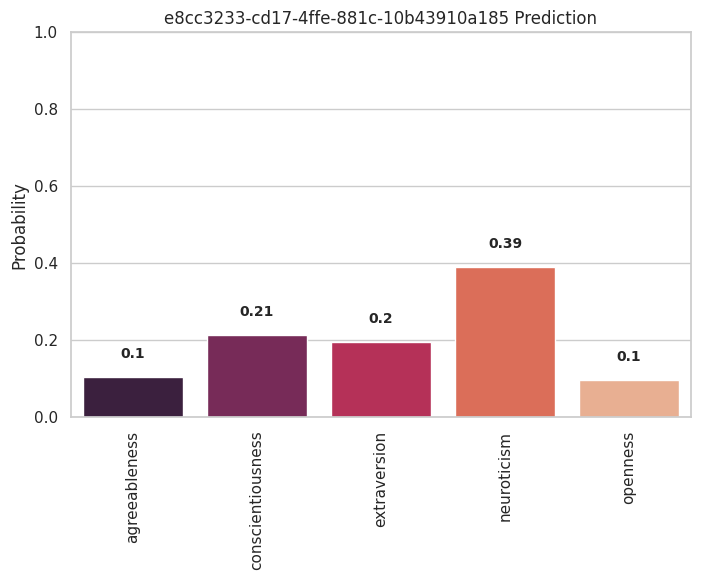

In [ ]:
main("/content/drive/MyDrive/shri_vignesh_test")

# External Test


In [ ]:
main("/content/drive/MyDrive/extern_test")

Video Name :  external


UnknownValueError: ignored